# 1. Baseline Model: from experiment 1

In [37]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import os

data = pd.read_csv("../10_Data_Clean/model_track_data.csv")

# Configuration
TARGET_VARIABLE = 'PCT_PRICE_CHANGE_DETRENDED (%)'
RAW_TARGET_VARIABLE = 'PCT_PRICE_CHANGE (%)'
YEAR_COLUMN = 'YEAR'
GEO_UNIQUE_ID_COLUMN = 'GEO_UNIQUE_ID'
TRAIN_YEAR_CUTOFF = 2020

# XGBoost specific params (can be tuned later)
XGB_PARAMS = {
    'objective': 'reg:squarederror', # Objective function for regression
    'n_estimators': 100,            # Number of boosting rounds/trees
    'learning_rate': 0.1,           # Step size shrinkage
    'max_depth': 5,                 # Maximum tree depth
    'subsample': 0.8,               # Fraction of samples used per tree
    'colsample_bytree': 0.8,        # Fraction of features used per tree
    'random_state': 42,
    'n_jobs': -1                    # Use all available CPU cores
}

# Step 1: Detrending Target Variable
print("--- Detrending Target Variable ---")
# Ensure YEAR is numeric
data[YEAR_COLUMN] = pd.to_numeric(data[YEAR_COLUMN], errors='coerce')
data = data.dropna(subset=[YEAR_COLUMN, RAW_TARGET_VARIABLE]) # Drop rows where year or target is missing

trend_model = LinearRegression()
# Reshape YEAR for sklearn compatibility
trend_model.fit(data[[YEAR_COLUMN]], data[RAW_TARGET_VARIABLE])
predicted_trend = trend_model.predict(data[[YEAR_COLUMN]])
data[TARGET_VARIABLE] = data[RAW_TARGET_VARIABLE] - predicted_trend
print(f"Target variable '{TARGET_VARIABLE}' created.")
print(f"Target variable mean: {data[TARGET_VARIABLE].mean():.4f}, std: {data[TARGET_VARIABLE].std():.4f}")




# Step 2: Define Feature Sets
print("\n--- Defining Feature Sets ---")
# Carefully select features, avoiding leakage from future/target variables
baseline_features = [
    'Median_Household_Income', 'Total_Population', 'Avg_Household_Size',
    'Gini_Index', 'Employment_Rate', 'Below_Poverty_Rate',
    'Rate_College_or_Higher', 'Black_Portion', 'White_Portion',
    'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
    # Lagged Price Features
    'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1', 'PRICE_CHANGE_DIFF',
    'ROLLING_1yr_PRICE_CHANGE', 'ROLLING_2yr_PRICE_CHANGE_STD'
    # Avoid interaction terms involving FIRE here
]

wildfire_features = [
    'NUM_FIRES', 'TOTAL_AREA_BURNED_IN_M2', 'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_TRACT_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED',
    'PREV_MAX_PCT_TRACT_BURNED', 'FIRE_LAST_YEAR', 'FIRE_SHOCK',
    'YEARS_SINCE_LAST_FIRE', 'CUMULATIVE_AREA_BURNED_LAST_2YRS',
    # Interaction terms
    'FIRE_EXPOSED_x_PRICE_CHANGE_LAG1',
    'MAX_PCT_TRACT_BURNED_x_ROLLING_1yr_PRICE_CHANGE',
    'FIRE_EXPOSED_x_Median_Household_Income',
    'FIRE_EXPOSED_x_Below_Poverty_Rate'
]

# Ensure all defined features exist in the dataframe columns
baseline_features = [f for f in baseline_features if f in data.columns]
wildfire_features = [f for f in wildfire_features if f in data.columns]

# Combine for the second model
temp_all_features = list(set(baseline_features + wildfire_features)) 
all_features = sorted(temp_all_features)

# Verify no target/future leakage in feature lists
leaky_features = ['PRICE', 'NEXT_YEAR_PRICE', 'PRICE_CHANGE', RAW_TARGET_VARIABLE, TARGET_VARIABLE]






# Step 3: Sort Data and Temporal Split
print(f"\n--- Splitting Data: Train <= {TRAIN_YEAR_CUTOFF}, Test > {TRAIN_YEAR_CUTOFF} ---")
data = data.sort_values(by=[YEAR_COLUMN, GEO_UNIQUE_ID_COLUMN]).reset_index(drop=True)

train_data = data[data[YEAR_COLUMN] <= TRAIN_YEAR_CUTOFF].copy()
test_data = data[data[YEAR_COLUMN] > TRAIN_YEAR_CUTOFF].copy()


# Separate features (X) and target (y) for both sets
y_train = train_data[TARGET_VARIABLE]
y_test = test_data[TARGET_VARIABLE]

X_train_base = train_data[baseline_features]
X_test_base = test_data[baseline_features]

X_train_wf = train_data[all_features]
X_test_wf = test_data[all_features]
    
    



# Step 4: Imputation and Scaling
print("\n--- Applying Imputation and Scaling ---")

# --- Imputation ---
# Fit Imputer ONLY on training data, then transform both train and test
imputer_base = SimpleImputer(strategy='median')
X_train_base_imputed = imputer_base.fit_transform(X_train_base)
X_test_base_imputed = imputer_base.transform(X_test_base)
print(f"Imputed NaNs in Baseline features using median strategy.")

imputer_wf = SimpleImputer(strategy='median')
X_train_wf_imputed = imputer_wf.fit_transform(X_train_wf)
X_test_wf_imputed = imputer_wf.transform(X_test_wf)
print(f"Imputed NaNs in All features using median strategy.")

# --- Scaling ---
# Fit Scaler ONLY on training data, then transform both train and test
scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_base_imputed)
X_test_base_scaled = scaler_base.transform(X_test_base_imputed)
print(f"Scaled Baseline features using StandardScaler.")

scaler_wf = StandardScaler()
X_train_wf_scaled = scaler_wf.fit_transform(X_train_wf_imputed)
X_test_wf_scaled = scaler_wf.transform(X_test_wf_imputed)
print(f"Scaled All features using StandardScaler.")

# Convert back to DataFrames (maintains column names for importance plots)
X_train_base_scaled = pd.DataFrame(X_train_base_scaled, columns=baseline_features, index=X_train_base.index)
X_test_base_scaled = pd.DataFrame(X_test_base_scaled, columns=baseline_features, index=X_test_base.index)
X_train_wf_scaled = pd.DataFrame(X_train_wf_scaled, columns=all_features, index=X_train_wf.index)
X_test_wf_scaled = pd.DataFrame(X_test_wf_scaled, columns=all_features, index=X_test_wf.index)

print("Imputation and Scaling complete.")




# Step 5: Model Training
print("\n--- Training Models ---")

# --- Linear Regression ---
lr_base = LinearRegression()
lr_base.fit(X_train_base_scaled, y_train)
print("Trained Linear Regression (Baseline).")

lr_wf = LinearRegression()
lr_wf.fit(X_train_wf_scaled, y_train)
print("Trained Linear Regression (Wildfire Features).")

# --- Random Forest ---
# Using basic parameters; consider tuning these
rf_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_leaf=5)
rf_base.fit(X_train_base_scaled, y_train)
print("Trained Random Forest (Baseline).")

rf_wf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_leaf=5)
rf_wf.fit(X_train_wf_scaled, y_train)
print("Trained Random Forest (Wildfire Features).")

# --- XGBoost ---
xgb_base = XGBRegressor(**XGB_PARAMS)
xgb_base.fit(X_train_base_scaled, y_train)
print("Trained XGBoost (Baseline).")

xgb_wf = XGBRegressor(**XGB_PARAMS)
xgb_wf.fit(X_train_wf_scaled, y_train)
print("Trained XGBoost (Wildfire Features).")



# Step 6: Evaluation on Test Set
print("\n--- Evaluating Models on Test Set ---")

results = {}
predictions = {}

models_to_evaluate = {
    "Linear Regression (Baseline)": (lr_base, X_test_base_scaled),
    "Linear Regression (Wildfire)": (lr_wf, X_test_wf_scaled),
    "Random Forest (Baseline)": (rf_base, X_test_base_scaled),
    "Random Forest (Wildfire)": (rf_wf, X_test_wf_scaled),
    "XGBoost (Baseline)": (xgb_base, X_test_base_scaled),
    "XGBoost (Wildfire)": (xgb_wf, X_test_wf_scaled)
}

for name, (model, X_test_data) in models_to_evaluate.items():
    y_pred = model.predict(X_test_data)
    predictions[name] = y_pred
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    print(f"\n--- {name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R2:   {r2:.4f} <<< Realistic performance estimate")
    
    
    # Step 7: Compare Results Summary
print("\n--- Comparison Summary (Test Set Performance) ---")
results_df = pd.DataFrame(results).T # Transpose for better readability
print(results_df.sort_values(by='R2', ascending=False)) # Sort by R2 score

# Explicit R2 comparisons
print("\n--- R2 Improvement from Wildfire Features ---")
for model_type in ["Linear Regression", "Random Forest", "XGBoost"]:
    base_name = f"{model_type} (Baseline)"
    wf_name = f"{model_type} (Wildfire)"
    if base_name in results and wf_name in results:
        base_r2 = results[base_name]["R2"]
        wf_r2 = results[wf_name]["R2"]
        improvement = wf_r2 - base_r2
        print(f"{model_type}:")
        print(f"  Baseline R2: {base_r2:.4f}")
        print(f"  Wildfire R2: {wf_r2:.4f}")
        print(f"  Improvement: {improvement:.4f} ({'IMPROVED' if improvement > 0 else ('WORSENED' if improvement < 0 else 'NO CHANGE')})")
    else:
        print(f"Could not compare {model_type}, models not found in results.") 

--- Detrending Target Variable ---
Target variable 'PCT_PRICE_CHANGE_DETRENDED (%)' created.
Target variable mean: 0.0000, std: 10.5283

--- Defining Feature Sets ---

--- Splitting Data: Train <= 2020, Test > 2020 ---

--- Applying Imputation and Scaling ---
Imputed NaNs in Baseline features using median strategy.
Imputed NaNs in All features using median strategy.
Scaled Baseline features using StandardScaler.
Scaled All features using StandardScaler.
Imputation and Scaling complete.

--- Training Models ---
Trained Linear Regression (Baseline).
Trained Linear Regression (Wildfire Features).
Trained Random Forest (Baseline).
Trained Random Forest (Wildfire Features).
Trained XGBoost (Baseline).
Trained XGBoost (Wildfire Features).

--- Evaluating Models on Test Set ---

--- Linear Regression (Baseline) ---
RMSE: 6.4929
MAE:  4.7510
R2:   0.5975 <<< Realistic performance estimate

--- Linear Regression (Wildfire) ---
RMSE: 6.4839
MAE:  4.7377
R2:   0.5986 <<< Realistic performance est

### Finally, we pick XGBoost with Wildfire which has the best prediction performance.
### xgb_wf & its Prediction Result: PCT_PRICE_CHANGE_DETRENDED (%)

In [38]:
#Use the best model xgb_wf to make predictions on the test set (with wildfire features)
y_pred_xgb_wf = xgb_wf.predict(X_test_wf_scaled)

# 2.1 Explore Data：All data, do not filter fire

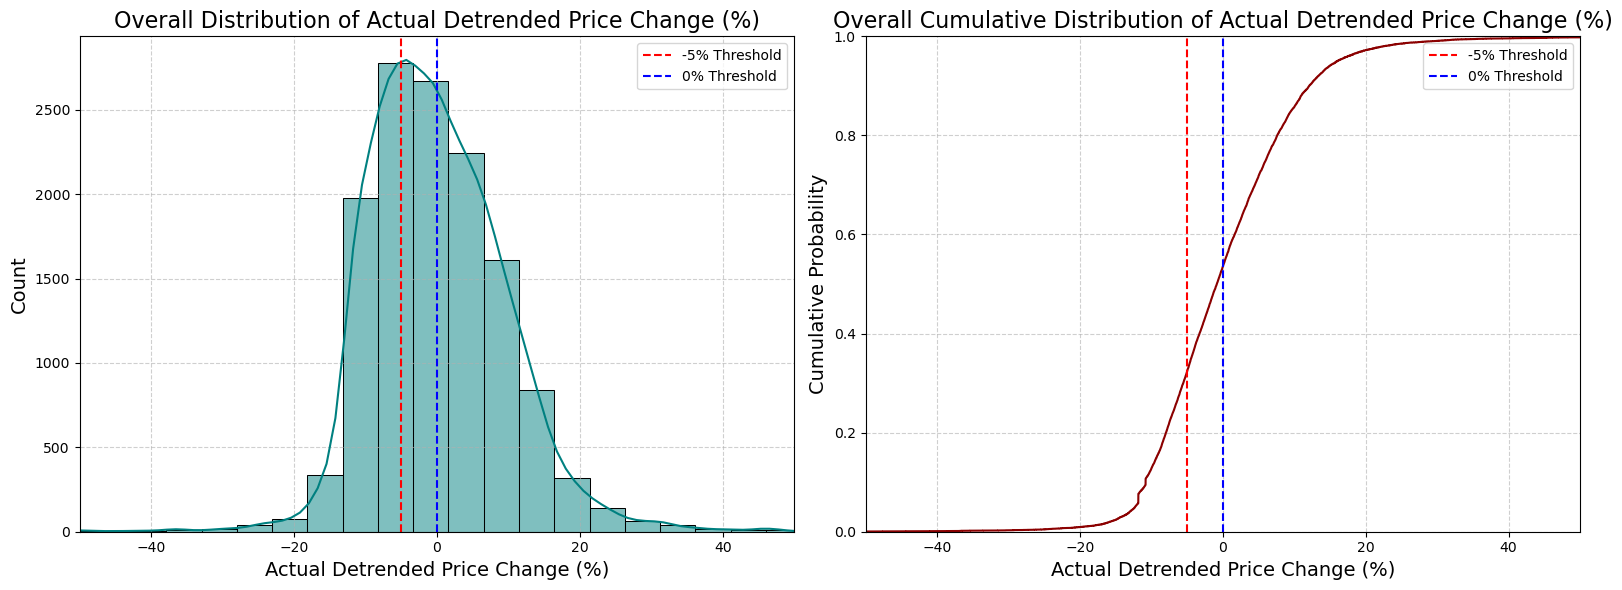

In [39]:
TARGET_VARIABLE = y_test

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(TARGET_VARIABLE, bins=50, kde=True, color='teal', ax=axes[0])
axes[0].axvline(x=-5, color='red', linestyle='--', label='-5% Threshold')
axes[0].axvline(x=0, color='blue', linestyle='--', label='0% Threshold')
axes[0].set_xlim(-50, 50)
axes[0].set_title('Overall Distribution of Actual Detrended Price Change (%)', fontsize=16)
axes[0].set_xlabel('Actual Detrended Price Change (%)', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

sns.ecdfplot(TARGET_VARIABLE, color='darkred', ax=axes[1])
axes[1].axvline(x=-5, color='red', linestyle='--', label='-5% Threshold')
axes[1].axvline(x=0, color='blue', linestyle='--', label='0% Threshold')
axes[1].set_xlim(-50, 50)
axes[1].set_title('Overall Cumulative Distribution of Actual Detrended Price Change (%)', fontsize=16)
axes[1].set_xlabel('Actual Detrended Price Change (%)', fontsize=14)
axes[1].set_ylabel('Cumulative Probability', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# 2.2 Explore Data：All data, filter fire

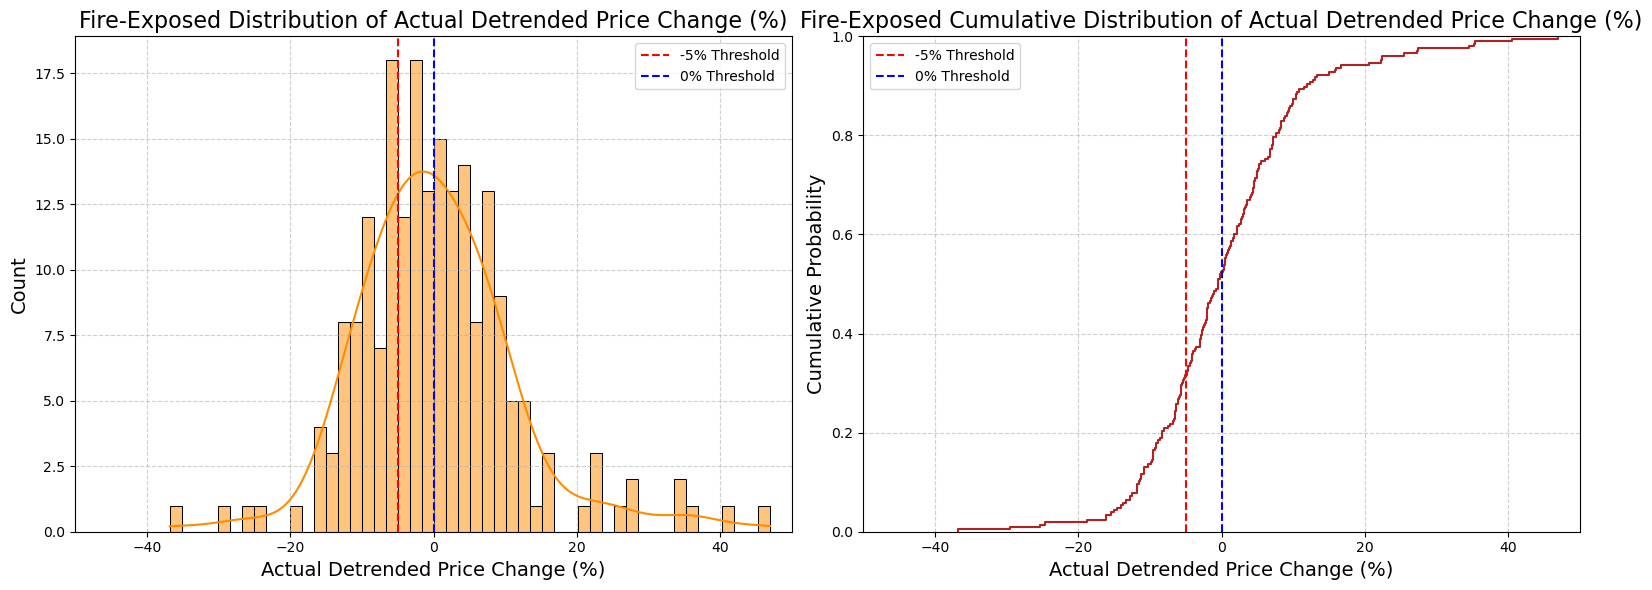

In [40]:
# fire-exposed sample
fire_exposed_idx = (test_data['FIRE_EXPOSED'] == 1)

# fire-exposed real data: y_test
TARGET_VARIABLE_FIRE = y_test[fire_exposed_idx]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(TARGET_VARIABLE_FIRE, bins=50, kde=True, color='darkorange', ax=axes[0])
axes[0].axvline(x=-5, color='red', linestyle='--', label='-5% Threshold')
axes[0].axvline(x=0, color='blue', linestyle='--', label='0% Threshold')
axes[0].set_xlim(-50, 50)
axes[0].set_title('Fire-Exposed Distribution of Actual Detrended Price Change (%)', fontsize=16)
axes[0].set_xlabel('Actual Detrended Price Change (%)', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

sns.ecdfplot(TARGET_VARIABLE_FIRE, color='firebrick', ax=axes[1])
axes[1].axvline(x=-5, color='red', linestyle='--', label='-5% Threshold')
axes[1].axvline(x=0, color='blue', linestyle='--', label='0% Threshold')
axes[1].set_xlim(-50, 50)
axes[1].set_title('Fire-Exposed Cumulative Distribution of Actual Detrended Price Change (%)', fontsize=16)
axes[1].set_xlabel('Actual Detrended Price Change (%)', fontsize=14)
axes[1].set_ylabel('Cumulative Probability', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# 3. [Increase/Decrease] [Severe Drop Ratio] (Total Data vs Fire-Exposed) Quantity Comparison Table

In [41]:
#Overall
total_samples = len(y_test)
severe_samples = (y_test <= -5).sum()
small_moderate_samples = ((y_test > -5) & (y_test <= 0)).sum()
increase_samples = (y_test > 0).sum()

print("=== Overall Test Set ===")
print(f"Total samples: {total_samples}")
print(f"Severe Drop (≤ -5%): {severe_samples} ({severe_samples/total_samples*100:.2f}%)")
print(f"Small/Moderate Drop (-5% to 0%): {small_moderate_samples} ({small_moderate_samples/total_samples*100:.2f}%)")
print(f"Increase (> 0%): {increase_samples} ({increase_samples/total_samples*100:.2f}%)")

# Fire-Exposed
fire_exposed_idx = (test_data['FIRE_EXPOSED'] == 1)
y_test_fire = y_test[fire_exposed_idx]

fire_total = len(y_test_fire)
fire_severe = (y_test_fire <= -5).sum()
fire_small_moderate = ((y_test_fire > -5) & (y_test_fire <= 0)).sum()
fire_increase = (y_test_fire > 0).sum()

print("\n=== Fire-Exposed Test Set ===")
print(f"Total samples: {fire_total}")
print(f"Severe Drop (≤ -5%): {fire_severe} ({fire_severe/fire_total*100:.2f}%)")
print(f"Small/Moderate Drop (-5% to 0%): {fire_small_moderate} ({fire_small_moderate/fire_total*100:.2f}%)")
print(f"Increase (> 0%): {fire_increase} ({fire_increase/fire_total*100:.2f}%)")


=== Overall Test Set ===
Total samples: 13238
Severe Drop (≤ -5%): 4277 (32.31%)
Small/Moderate Drop (-5% to 0%): 2808 (21.21%)
Increase (> 0%): 6153 (46.48%)

=== Fire-Exposed Test Set ===
Total samples: 206
Severe Drop (≤ -5%): 65 (31.55%)
Small/Moderate Drop (-5% to 0%): 43 (20.87%)
Increase (> 0%): 98 (47.57%)


Across the overall test set, approximately 32% of properties experienced a severe price drop (≤ -5%).
In fire-exposed areas, a similar proportion (31.55%) experienced severe drops.
Additionally, the distribution of small/moderate drops and price increases in fire-exposed areas closely mirrors that of the overall dataset.


# 4. Comparison: True (y_test) vs Predicted (y_pred_xgb_wf) 


In [42]:
# 1. Define a function to categorize the distribution into three groups
def categorize_distribution(y_values, name="Dataset"):
    total = len(y_values)
    severe = (y_values <= -5).sum()
    small_moderate = ((y_values > -5) & (y_values <= 0)).sum()
    increase = (y_values > 0).sum()
    return {
        "Name": name,
        "Total": total,
        "Severe Drop (≤ -5%)": f"{severe} ({severe/total*100:.2f}%)",
        "Small/Moderate Drop (-5% to 0%)": f"{small_moderate} ({small_moderate/total*100:.2f}%)",
        "Increase (>0%)": f"{increase} ({increase/total*100:.2f}%)"
    }

# 2. Categorize the overall test set (actual and predicted)
overall_actual = categorize_distribution(y_test, "Overall Actual")
overall_predicted = categorize_distribution(y_pred_xgb_wf, "Overall Predicted")

# 3. Categorize the fire-exposed subset (actual and predicted)
fire_idx = (test_data['FIRE_EXPOSED'] == 1)
y_test_fire = y_test[fire_idx]
y_pred_fire = y_pred_xgb_wf[fire_idx]

fire_actual = categorize_distribution(y_test_fire, "Fire-Exposed Actual")
fire_predicted = categorize_distribution(y_pred_fire, "Fire-Exposed Predicted")

# 4. Combine all results into a summary table
import pandas as pd

distribution_comparison = pd.DataFrame([
    overall_actual,
    overall_predicted,
    fire_actual,
    fire_predicted
])

print(distribution_comparison)

                     Name  Total Severe Drop (≤ -5%)  \
0          Overall Actual  13238       4277 (32.31%)   
1       Overall Predicted  13238       2444 (18.46%)   
2     Fire-Exposed Actual    206         65 (31.55%)   
3  Fire-Exposed Predicted    206         39 (18.93%)   

  Small/Moderate Drop (-5% to 0%) Increase (>0%)  
0                   2808 (21.21%)  6153 (46.48%)  
1                   3361 (25.39%)  7433 (56.15%)  
2                     43 (20.87%)    98 (47.57%)  
3                     51 (24.76%)   116 (56.31%)  


In the overall test set, the model significantly underestimates severe price declines (predicted 18.46%, actual 32.31%).  
In the fire-affected areas, the model also underestimates the proportion of severe declines (predicted 18.93%, actual 31.55%).  
At the same time, the model tends to overestimate the proportion of small declines and increases.
This suggests that the model has a systematic tendency to underestimate when faced with extreme negative results, especially in high-risk fire-exposed areas.    
Because the distribution of actual and predicted outcomes is similar between fire-exposed and overall datasets, it is reasonable to apply a unified model across all properties without explicitly separating fire-exposed and non-exposed regions.

# 5. Train Model to different Level

## 5.1 Performance comparison of Drop Group vs Increase Group

In [43]:
# Set the threshold for severe decline
severe_threshold = 0

# Group by real y_test
severe_idx = (y_test <=  severe_threshold)
small_moderate_idx = (y_test > severe_threshold) 

# Extract test set features and targets for each group
X_test_severe = X_test_wf_scaled[severe_idx]
y_test_severe = y_test[severe_idx]

X_test_small_moderate = X_test_wf_scaled[small_moderate_idx]
y_test_small_moderate = y_test[small_moderate_idx]

# Use the existing model xgb_wf to predict on each group
y_pred_severe = xgb_wf.predict(X_test_severe)
y_pred_small_moderate = xgb_wf.predict(X_test_small_moderate)

# Evaluate performance separately

print("===  Drop Group ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_severe, y_pred_severe)):.4f}")
print(f"R2 Score: {r2_score(y_test_severe, y_pred_severe):.4f}")

print("\n=== Increase Group ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_small_moderate, y_pred_small_moderate)):.4f}")
print(f"R2 Score: {r2_score(y_test_small_moderate, y_pred_small_moderate):.4f}")

print("\n=== Overall Test Set ===")
y_pred_all = xgb_wf.predict(X_test_wf_scaled)  
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_all)):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_all):.4f}")

===  Drop Group ===
RMSE: 3.6740
R2 Score: 0.4907

=== Increase Group ===
RMSE: 3.6858
R2 Score: 0.8060

=== Overall Test Set ===
RMSE: 3.6795
R2 Score: 0.8707


The current model significantly underestimates severe price declines and performs notably worse on properties experiencing price drops (R² = 0.49) compared to price increases (R² = 0.81).
This suggests that designing a specialized model or adjustment focusing on predicting downward price movements could meaningfully improve overall predictive performance.



## 5.2 Performance comparison of Severe Drop vs Small/Moderate Drop Group

In [44]:
# Set the threshold for severe decline
severe_threshold = -5

# Group by real y_test
severe_idx = (y_test <= severe_threshold)
small_moderate_idx = (y_test > severe_threshold) & (y_test < 0)

# Extract test set features and targets for each group
X_test_severe = X_test_wf_scaled[severe_idx]
y_test_severe = y_test[severe_idx]

X_test_small_moderate = X_test_wf_scaled[small_moderate_idx]
y_test_small_moderate = y_test[small_moderate_idx]

# Use the existing model xgb_wf to predict on each group
y_pred_severe = xgb_wf.predict(X_test_severe)
y_pred_small_moderate = xgb_wf.predict(X_test_small_moderate)

# Evaluate performance separately

print("=== Severe Drop Group ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_severe, y_pred_severe)):.4f}")
print(f"R2 Score: {r2_score(y_test_severe, y_pred_severe):.4f}")

print("\n=== Small/Moderate Drop Group ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_small_moderate, y_pred_small_moderate)):.4f}")
print(f"R2 Score: {r2_score(y_test_small_moderate, y_pred_small_moderate):.4f}")


=== Severe Drop Group ===
RMSE: 4.1422
R2 Score: 0.2019

=== Small/Moderate Drop Group ===
RMSE: 2.8150
R2 Score: -2.7068


Based on the experimental results, the current model underperforms significantly in predicting properties with price declines (y <= 0), achieving an R² of only 0.4907 compared to 0.8060 for price increases.
In addition, the model systematically underestimates the frequency of severe price drops.
Therefore, it is reasonable and justified to propose designing a specialized model or adjustment specifically targeting the price drop region (y= 0) to improve predictive performance in critical cases.